# preprocessing

In [84]:
!rm -rf TabularDS  # Remove the existing directory
!git clone https://github.com/ItamarBerger/TabularDS


Cloning into 'TabularDS'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 397 (delta 0), reused 5 (delta 0), pack-reused 387 (from 2)
Receiving objects: 100% (397/397), 24.57 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (172/172), done.
Updating files: 100% (17/17), done.


In [96]:
# load dataset
import pandas as pd
data = pd.read_csv('/content/TabularDS/final_project/data/rating.csv')
movies_data = pd.read_csv('/content/TabularDS/final_project/data/movie.csv')

In [97]:
df = data
data.head()

,userId,movieId,rating,timestamp
0,122270,8360,3.5,2012-04-22 01:07:04
1,49018,32,2.0,2001-09-11 07:50:36
2,89527,109374,3.5,2015-01-06 09:26:40
3,106704,1060,3.0,2000-01-22 21:27:57
4,47791,1732,2.0,2006-01-19 15:48:23


In [105]:
movie_popularity = data.groupby('movieId')['userId'].nunique().sort_values(ascending=False)

# Select the top 10% most popular movies
top_10_percent_count = int(0.1 * len(movie_popularity))
top_movies = movie_popularity.head(top_10_percent_count).index.tolist()

# Filter dataset to only include these movies
filtered_df = data[data['movieId'].isin(top_movies)]


user_movie_matrix = filtered_df.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='count').fillna(0)
user_movie_matrix = user_movie_matrix.map(lambda x: 1 if x > 0 else 0)  # Convert to binary


# preprocess movies with titles
user_movie_matrix_with_titles = user_movie_matrix.copy()
movie_titles = movies_data.set_index('movieId')['title']
user_movie_matrix_with_titles.columns = movie_titles[user_movie_matrix_with_titles.columns]

In [119]:
transactions = user_movie_matrix_with_titles.drop(columns=['Cluster'])
df =  user_movie_matrix
min_support = 0.00005

In [109]:
user_movie_matrix.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,60069,63082,68157,68358,68954,69122,70286,72998,79132,80463
userId,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Apriori for rule mining

In [92]:
# data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# data.dropna(subset=['InvoiceNo', 'Description'], inplace=True)

# transactions = data.groupby('CustomerID')['Description'].apply(list).tolist()
# print(f"number of transactions is: {len(transactions)}")

In [120]:
import pandas as pd
# from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder



from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(rules)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                                           antecedents  \
0    (Star Wars: Episode I - The Phantom Menace (19...   
1                                  (Waterworld (1995))   
2                                  (Braveheart (1995))   
3                                (Forrest Gump (1994))   
4             (One Flew Over the Cuckoo's Nest (1975))   
..                                                 ...   
247                 (Silence of the Lambs, The (1991))   
248                                  (Fly, The (1986))   
249                             (Jurassic Park (1993))   
250                     (Beverly Hills Cop III (1994))   
251             (Independence Day (a.k.a. ID4) (1996))   

                                           consequents  antecedent support  \
0                                  (Waterworld (1995))            0.003063   
1    (Star Wars: Episode I - The Phantom Menace (19...            0.003197   
2                                (Forrest Gump (1994))            0.0

# Baseline apriori results

In [121]:
import numpy as np

# Calculate the average support, confidence, and lift from the rules DataFrame
avg_support = np.mean(rules['support'])
avg_confidence = np.mean(rules['confidence'])
avg_lift = np.mean(rules['lift'])

# Print the metrics
print(f"\nMetrics: Support average: {avg_support:.4f}, Confidence average: {avg_confidence:.4f}, Lift average: {avg_lift:.4f}")

# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.0001, Confidence average: 0.0400, Lift average: 18.2813


## Visualize top rules
### (sorted by lift)

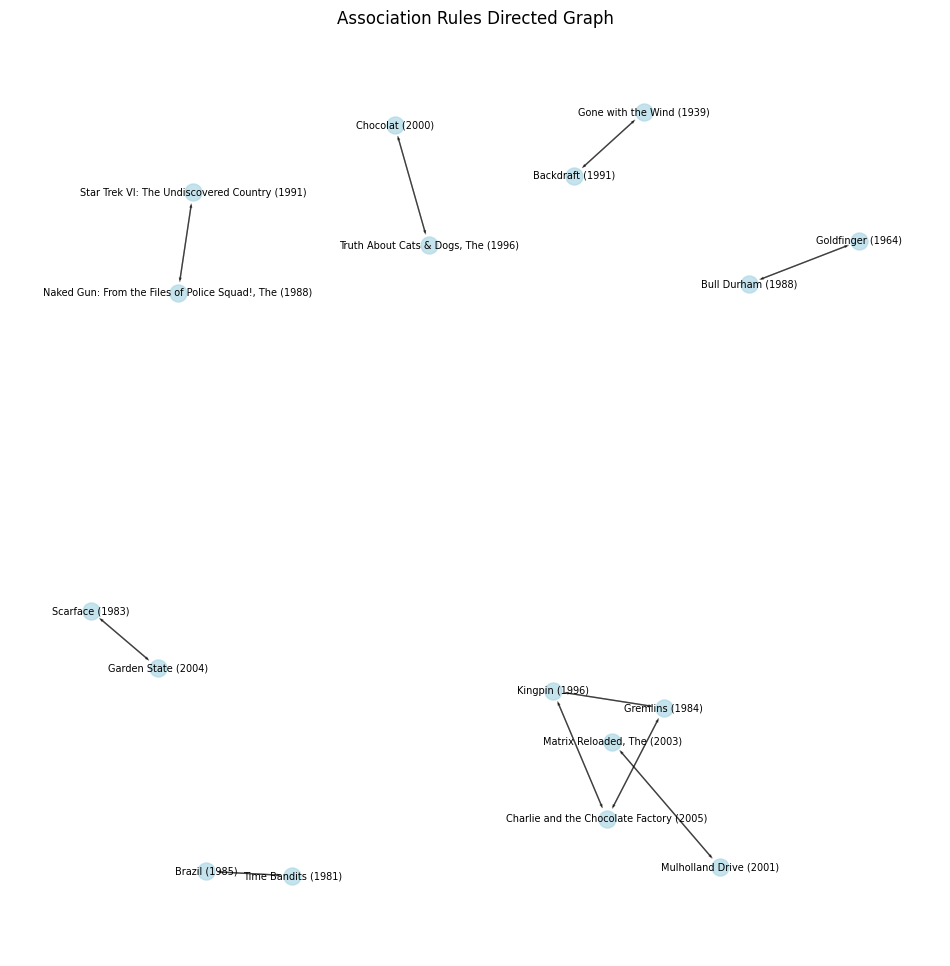

In [125]:
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
def plot_topk_rules_in_graph(rules, frequent_itemsets, k=20):

    # Create a directed graph
    G = nx.DiGraph()
    narrow_rules = rules.sort_values(by='lift', ascending=False).head(k)
    # Add nodes and directed edges
    for _, rule in narrow_rules.iterrows():
        antecedent = ', '.join(list(rule['antecedents']))
        consequent = ', '.join(list(rule['consequents']))

        # Add a directed edge from antecedent to consequent
        G.add_edge(antecedent, consequent)

    # Draw the directed graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.3, iterations=20)  # Layout for the graph

    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=150, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, arrowstyle='->', arrowsize=3)
    nx.draw_networkx_labels(G, pos, font_size=7, font_color='black')

    # Add edge labels (optional, if you want to display lift, confidence, or support)
    # edge_labels = nx.get_edge_attributes(G, 'weight')
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Association Rules Directed Graph")
    plt.axis('off')
    plt.show()

plot_topk_rules_in_graph(rules, frequent_itemsets)

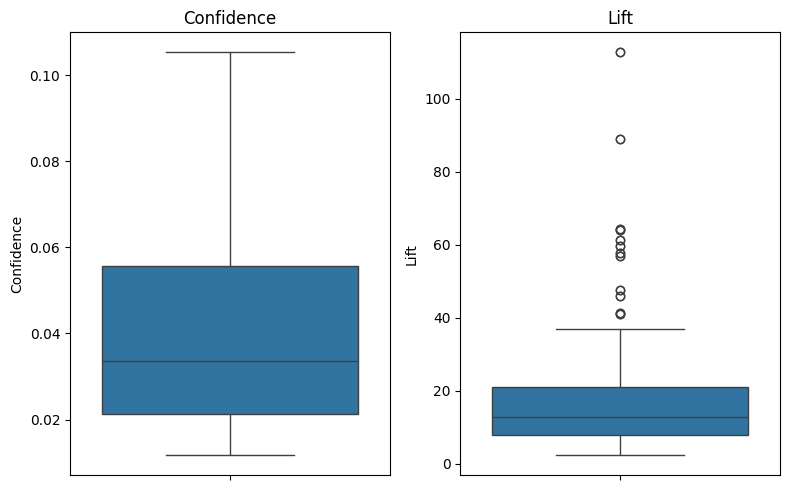

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics_boxplots(rules):
  if not rules.empty:
      fig, axes = plt.subplots(1, 2, figsize=(8, 5))

      # plot Confidence
      sns.boxplot(data=rules['confidence'], ax=axes[0])
      axes[0].set_title('Confidence')
      axes[0].set_ylabel('Confidence')

      # plot Lift
      sns.boxplot(data=rules['lift'], ax=axes[1])
      axes[1].set_title('Lift')
      axes[1].set_ylabel('Lift')

      # show plot
      plt.tight_layout()
      plt.show()
  else:
      print("No rules to plot.")


# Cluster items + Apriori


In [132]:
from sklearn.cluster import KMeans


def add_cluster_users_col(num_clusters, transactions_matrix):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    user_clusters = kmeans.fit_predict(transactions_matrix)
    transactions_matrix['Cluster'] = user_clusters


num_clusters = 40
add_cluster_users_col(num_clusters,user_movie_matrix_with_titles)
df = user_movie_matrix_with_titles

<ipython-input-133-048bf41f4725>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


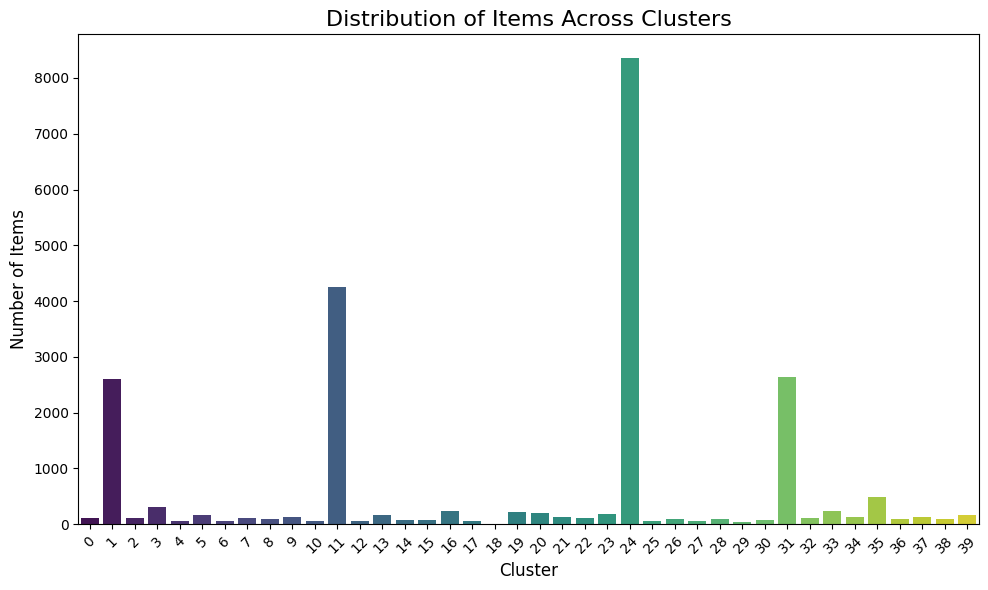

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the distribution of clusters
cluster_counts = df['Cluster'].value_counts().sort_index()

# Plot the distribution using seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Items Across Clusters', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [135]:
from sklearn.metrics import silhouette_score
silhouette_score(df, df['Cluster'])
print(silhouette_score)


<function silhouette_score at 0x7a8fad762de0>


In [79]:

# Function to process a single cluster
def process_cluster(cluster_id, df):
    print(f"\nProcessing Cluster {cluster_id}...")

    # Extract transactions for the cluster
    cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])


    # Run Apriori
    from mlxtend.frequent_patterns import fpgrowth, association_rules
    # from scipy.sparse import csr_matrix
    # cluster_data_sparse = csr_matrix(cluster_data)
    # df_cluster_data = pd.DataFrame.sparse.from_spmatrix(cluster_data_sparse, columns=cluster_data.columns)

    scale_k = min_support  * np.sqrt(len(transactions))
    min_support =  scale_k / np.sqrt(len(cluster_data)) if len(cluster_data) > 0 else 0
    print(f"min_support: {min_support}")


    frequent_itemsets = fpgrowth(cluster_data, min_support=min_support, use_colnames=True)
    if frequent_itemsets.empty:
        print(f"No frequent itemsets found in Cluster {cluster_id}.")
        return None
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    print(f"Cluster {cluster_id}: {len(rules)} rules generated.")

    return cluster_id, {"frequent_itemsets": frequent_itemsets, "rules": rules}

# Process clusters sequentially (without parallel computation)
cluster_results = {}
# Loop through all unique cluster IDs
for cluster_id in sorted(df['Cluster'].unique()):
    if df['Cluster'].value_counts()[cluster_id] < 30:
        cluster_results[cluster_id] = cluster_id, {"frequent_itemsets": None, "rules": None}
        continue
    cluster_results[cluster_id] = process_cluster(cluster_id, df)



Processing Cluster 0...
min_support: 0.0007288528075642843
Cluster 0: 318 rules generated.

Processing Cluster 1...
min_support: 0.0006364808824065848
Cluster 1: 222 rules generated.

Processing Cluster 2...
min_support: 0.0006086546856106421


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_n

Cluster 2: 212 rules generated.

Processing Cluster 3...
min_support: 0.0009530088176148283
Cluster 3: 134 rules generated.

Processing Cluster 5...
min_support: 0.0006711780687716189
Cluster 5: 326 rules generated.

Processing Cluster 6...
min_support: 0.0001102456883810192


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Cluster 6: 9096 rules generated.

Processing Cluster 7...
min_support: 0.0005755304458650707
Cluster 7: 202 rules generated.

Processing Cluster 8...
min_support: 0.0009607886105165698
Cluster 8: 66 rules generated.

Processing Cluster 9...
min_support: 0.0007823459703937283
Cluster 9: 186 rules generated.

Processing Cluster 10...
min_support: 0.0008723221572022265
Cluster 10: 138 rules generated.

Processing Cluster 11...
min_support: 0.0009769374492059443
Cluster 11: 76 rules generated.

Processing Cluster 12...
min_support: 0.0005969861012312524
Cluster 12: 312 rules generated.

Processing Cluster 13...
min_support: 0.0008139229621010174
Cluster 13: 110 rules generated.

Processing Cluster 14...
min_support: 0.0008496605657102587
Cluster 14: 230 rules generated.

Processing Cluster 15...
min_support: 0.000705916839344973
Cluster 15: 50 rules generated.


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be dis


Processing Cluster 16...
min_support: 0.0006658722300649379
Cluster 16: 90 rules generated.

Processing Cluster 17...
min_support: 0.00090999353585293
Cluster 17: 48 rules generated.

Processing Cluster 18...
min_support: 0.000641109895267745
Cluster 18: 450 rules generated.

Processing Cluster 19...
min_support: 0.0006967288098555697
Cluster 19: 230 rules generated.

Processing Cluster 20...
min_support: 0.0008496605657102587
Cluster 20: 256 rules generated.

Processing Cluster 21...
min_support: 0.0006297216018008656
Cluster 21: 124 rules generated.

Processing Cluster 22...
min_support: 0.000587758558167711
Cluster 22: 130 rules generated.

Processing Cluster 23...
min_support: 0.001050770025771017
Cluster 23: 78 rules generated.

Processing Cluster 24...
min_support: 0.0009167593802050949


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_n

Cluster 24: 52 rules generated.

Processing Cluster 25...
min_support: 0.0009607886105165698
Cluster 25: 164 rules generated.

Processing Cluster 26...
min_support: 0.0008442658409094746
Cluster 26: 166 rules generated.

Processing Cluster 27...
min_support: 0.0010118390098321876
Cluster 27: 54 rules generated.

Processing Cluster 28...
min_support: 0.0007658736841020196
Cluster 28: 162 rules generated.

Processing Cluster 29...
min_support: 6.246395856599167e-05


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Cluster 29: 11246 rules generated.

Processing Cluster 30...
min_support: 0.0011312704041354248
Cluster 30: 144 rules generated.

Processing Cluster 31...
min_support: 0.001050770025771017
Cluster 31: 112 rules generated.

Processing Cluster 32...
min_support: 0.0007028138931616624
Cluster 32: 300 rules generated.

Processing Cluster 33...
min_support: 0.0009236784170813012
Cluster 33: 58 rules generated.

Processing Cluster 34...
min_support: 0.0009379998667377304
Cluster 34: 304 rules generated.

Processing Cluster 35...
min_support: 0.0012506664889836406
Cluster 35: 216 rules generated.

Processing Cluster 36...
min_support: 0.000985323332193812
Cluster 36: 196 rules generated.

Processing Cluster 37...
min_support: 0.0010027640371920575
Cluster 37: 124 rules generated.

Processing Cluster 38...
min_support: 0.0006126989472816156
Cluster 38: 884 rules generated.

Processing Cluster 39...
min_support: 0.0008139229621010174


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_n

Cluster 39: 70 rules generated.


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


    Avg Support  Avg Confidence     Avg Lift
0      0.009493        0.780112    59.377358
1      0.007259        0.731707    64.405405
2      0.006641        0.721077    67.198113
3      0.016129        0.794415    36.507463
4      0.000000        0.000000     0.000000
5      0.008049        0.764101    66.387870
6      0.000218        0.569270  1572.086034
7      0.005999        0.698293    68.764898
8      0.016393        0.642325    17.363636
9      0.010870        0.776648    50.903226
10     0.013709        0.677830    26.304348
11     0.016949        0.663693    19.315789
12     0.006451        0.808970    97.615385
13     0.011765        0.721497    37.654545
14     0.012821        0.854069    55.234783
15     0.009912        0.504956     1.000000
16     0.007874        0.702362    51.400000
17     0.015319        0.599571    13.500000
18     0.007299        0.829231    90.209349
19     0.008996        0.743441    56.434783
20     0.012821        0.841897    53.335938
21     0.0

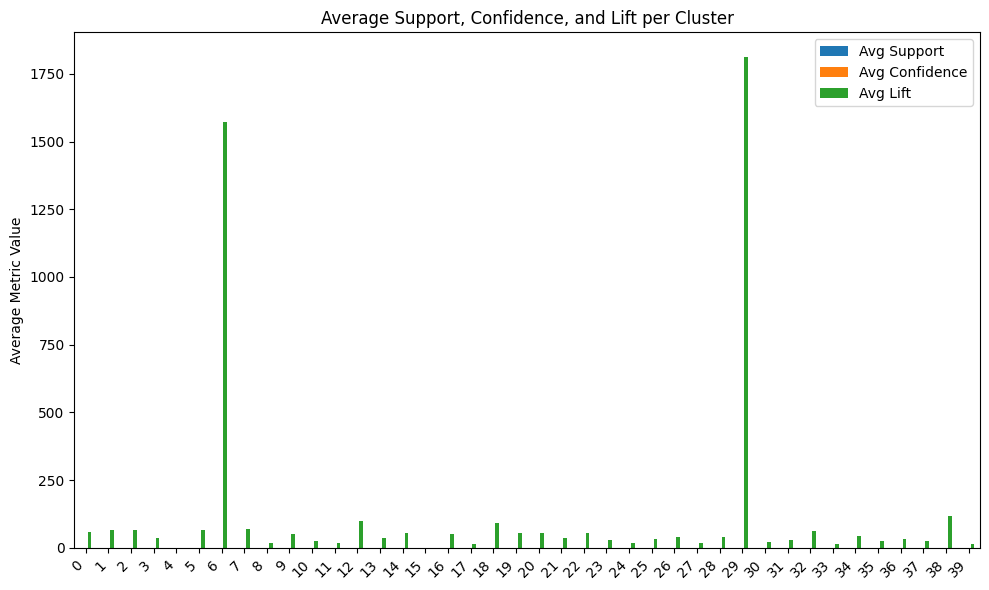

In [80]:
import matplotlib.pyplot as plt

# Initialize dictionary to store average metrics per cluster
cluster_metrics = {}

for cluster_id, data in cluster_results.items():
    # Access the dictionary that is the second element of the tuple
    rules = data[1]["rules"]

    if rules is not None and not rules.empty:
        avg_support = rules["support"].mean()
        avg_confidence = rules["confidence"].mean()
        avg_lift = rules["lift"].mean()
    else:
        avg_support, avg_confidence, avg_lift = 0, 0, 0  # Handle empty clusters

    cluster_metrics[cluster_id] = {
        "Avg Support": avg_support,
        "Avg Confidence": avg_confidence,
        "Avg Lift": avg_lift
    }

# Convert dictionary to DataFrame for easier plotting
metrics_df = pd.DataFrame.from_dict(cluster_metrics, orient="index")
print(metrics_df)

# Plotting the metrics
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric for every cluster
metrics_df.plot(kind='bar', ax=ax)

# Adding labels and title
ax.set_ylabel('Average Metric Value')
ax.set_title('Average Support, Confidence, and Lift per Cluster')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()
